In [1]:
!pip install descartes
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install pandas

     |████████████████████████████████| 972kB 5.2MB/s 
     |████████████████████████████████| 14.8MB 306kB/s 
     |████████████████████████████████| 6.5MB 42.4MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime, nltk, warnings
import plotly.graph_objs as go

In [3]:
#read the datafile
path="/content/drive/MyDrive/Nascomm project/data.csv"
df_initial = pd.read_csv(path,encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
df_initial[:10]

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


#### 1. Number of orders from each country

In [4]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
print(temp)
countries = temp['Country'].value_counts()
print(countries)
print('number of countries in dataframe: {}'.format(len(countries)))

      CustomerID InvoiceNo         Country
0          12346    541431  United Kingdom
1          12346   C541433  United Kingdom
2          12347    537626         Iceland
3          12347    542237         Iceland
4          12347    549222         Iceland
...          ...       ...             ...
22185      18283    579673  United Kingdom
22186      18283    580872  United Kingdom
22187      18287    554065  United Kingdom
22188      18287    570715  United Kingdom
22189      18287    573167  United Kingdom

[22190 rows x 3 columns]
United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan   

In [5]:
fig = go.Figure(data=go.Choropleth(
    locations = countries.index,
    locationmode = 'country names',
    z = countries,
    text = countries.index,
    colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'num orders',
))
fig.update_layout(
    title_text='Number of orders per country',
    geo=dict(
        showframe=True,
        showcoastlines=True,
        projection_type='mercator'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
    )]
)

fig.show()


#### 2. purchases divided according to total prizes


In [22]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [23]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True,errors="ignore")
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True,errors="ignore")
#df_cleaned.to_csv("/content/drive/MyDrive/Nascomm project/CleanedData.csv",index=False,header=True)

In [24]:
#df_cleaned=pd.read_csv("/content/drive/MyDrive/Nascomm project/CleanedData.csv",encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID':str})
#print(df_cleaned)

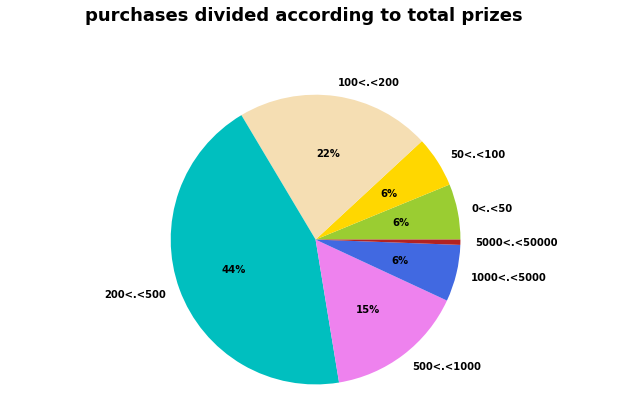

In [25]:

remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:10]
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
#representing in pichart     
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "purchases divided according to total prizes", ha='center', fontsize = 18);

#### 3. Total Quantity ordered for top 30 products

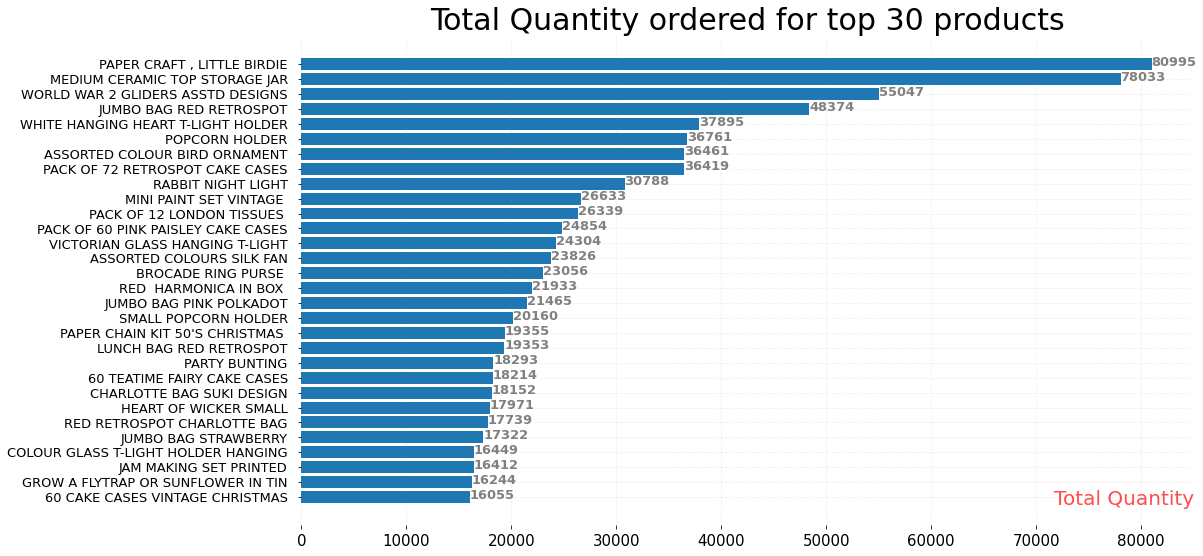

In [112]:
temp=df_cleaned[['Description','Quantity']].groupby(['Description']).sum().reset_index()
sorted=temp.sort_values(by=["Quantity"],ascending=False)
sorted
top30=sorted[:30]
top30

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(16, 9))
ax.barh(top30["Description"],top30["Quantity"])
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False)
#ax.xaxis.set_ticks_position('none')
#ax.yaxis.set_ticks_position('none')
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 13) 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2) 
ax.invert_yaxis() 
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5,str(round((i.get_width()), 2)), fontsize = 13, fontweight ='bold', 
             color ='grey') 
ax.set_title('Total Quantity ordered for top 30 products', loc ='center',fontsize=30 )
fig.text(0.9, 0.15, 'Total Quantity', fontsize = 20, color ='red', ha ='right', va ='bottom', alpha = 0.7)
plt.show()



#### 4. Number of orders made by Top 30 customers

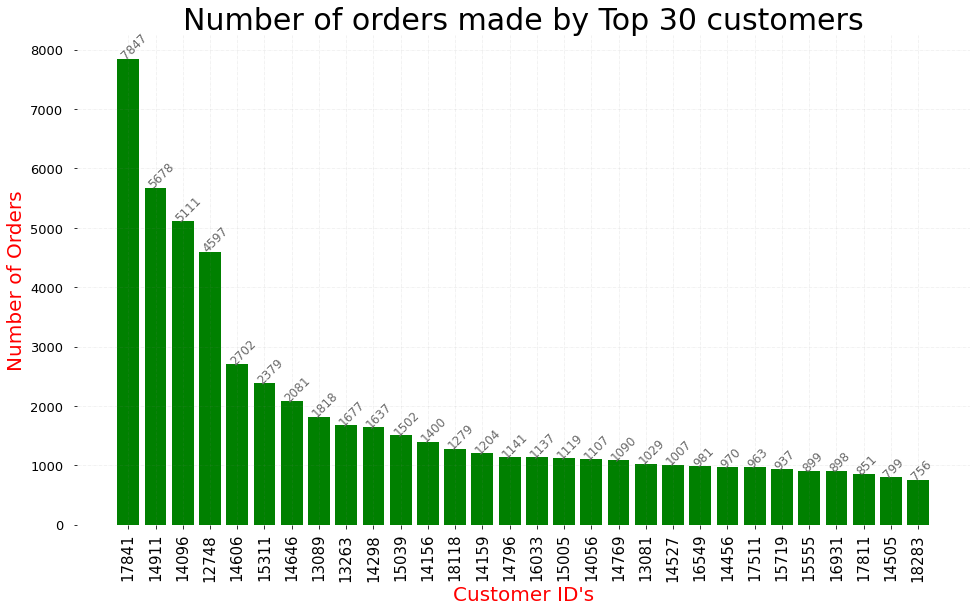

In [156]:
temp=df_cleaned[['CustomerID','InvoiceDate']].groupby(['CustomerID']).count().reset_index()
sorted=temp.sort_values(by=["InvoiceDate"],ascending=False)
#print(sorted[:30])
top30=sorted[:30]
top30

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(top30["CustomerID"],top30["InvoiceDate"],color="green")
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False)
plt.xticks(fontsize = 15,rotation=90) 
plt.yticks(fontsize = 13) 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2) 
ax.set_title('Number of orders made by Top 30 customers', loc ='center',fontsize=30 )
plt.ylabel('Number of Orders', fontsize = 20, color ='red')
plt.xlabel("Customer ID's",fontsize = 20, color ='red')
#ax.invert_yaxis() 
for i in ax.patches: 
  plt.text(i.get_x()+.05, i.get_height()+.7, str(round((i.get_height()), 2)), fontsize=12,color='dimgrey',rotation=45) 

plt.show()